# Lab Feedback 04

Here are some suggested solutions for the exercises for this week's practical session. Note that these aren't the only - or indeed necessarily the "best" - solutions.

Note that as we are dealing with populations in areas, we should use normalised values of crimes - i.e. crimes per head rather than raw counts of crimes. This is because the populations in these areas differ and therefore crimes will depend on the population. [See xkcd's take on this](http://xkcd.com/1138/).

## Part 1: Correlation Analysis

We will compute some correlation coefficients to quantity and amount of linear correspondance between two variables.

### 1. Load the data

We load the cleaned data into a Pandas dataframe

In [1]:
import pandas as pd

census = pd.read_csv('censusCrimeClean.csv')
#print (census.head()) # check

In [2]:
### 2. Select two variables

column1=census["medIncome"];
column2=census["ViolentCrimesPerPop"];

### 2. Do a Pearson's correlation

In [3]:
import scipy.stats as stats

corrPearson, pValPearson = stats.pearsonr(column1,column2)
print ("Pearson's correlation is", corrPearson, "with a p-value of",pValPearson)

Pearson's correlation is -0.424220616726126 with a p-value of 6.334424808048533e-88


### 3. Do a Spearman's correlation

In [4]:
corrSpearman, pValSpearman = stats.spearmanr(column1,column2)
print ("Spearman's correlation is", corrSpearman, "with a p-value of",pValSpearman)

Spearman's correlation is -0.482169950997556 with a p-value of 1.2978853095169542e-116


There's a small difference between the two computations. Spearman's is higher. This is because Spearman's rank-based approach is better at capturing non-linear relationships. The p-values are the probabilities that correlation of the population is not correlated (i.e. with a null-hypothesis that the population are not correlated). This is very low, indicating that the effect and sample size is high enough to be confident statistically significant.

### 4. Comment

Comment on the differences/similarities in relation to a scatterplot. Note the use of `alpha` to make the dots slightly transparent so you can estimate density better. Last week's solution encoded this into the colour as a fourth pair of hexadecimal digits.

In [5]:
import matplotlib.pyplot as plt
plt.suptitle('medIncome vs. ViolentCrimesPerPop')
plt.xlabel('medIncome')
plt.ylabel('ViolentCrimesPerPop')
plt.scatter(column1,column2 , c = "#D06B36", s = 30, alpha = 0.4, linewidth='0')

The scatterplot shows a negative correlation, but it doesn't look linear. This is perhaps why the Spearman's correlation shows a slightly higher correlation.

### 5. Check for other variables with crimes

The Pandas library has the useful function `corr()` which produces a data frame of all correlation coefficients for each pairwise pair of numeric variables. This is a matrix with variables as columns and rows which we can plot as a heatmap in Seaborne. The hue (red/blue) tells us whether the correlation is positive or negative and the darkness.

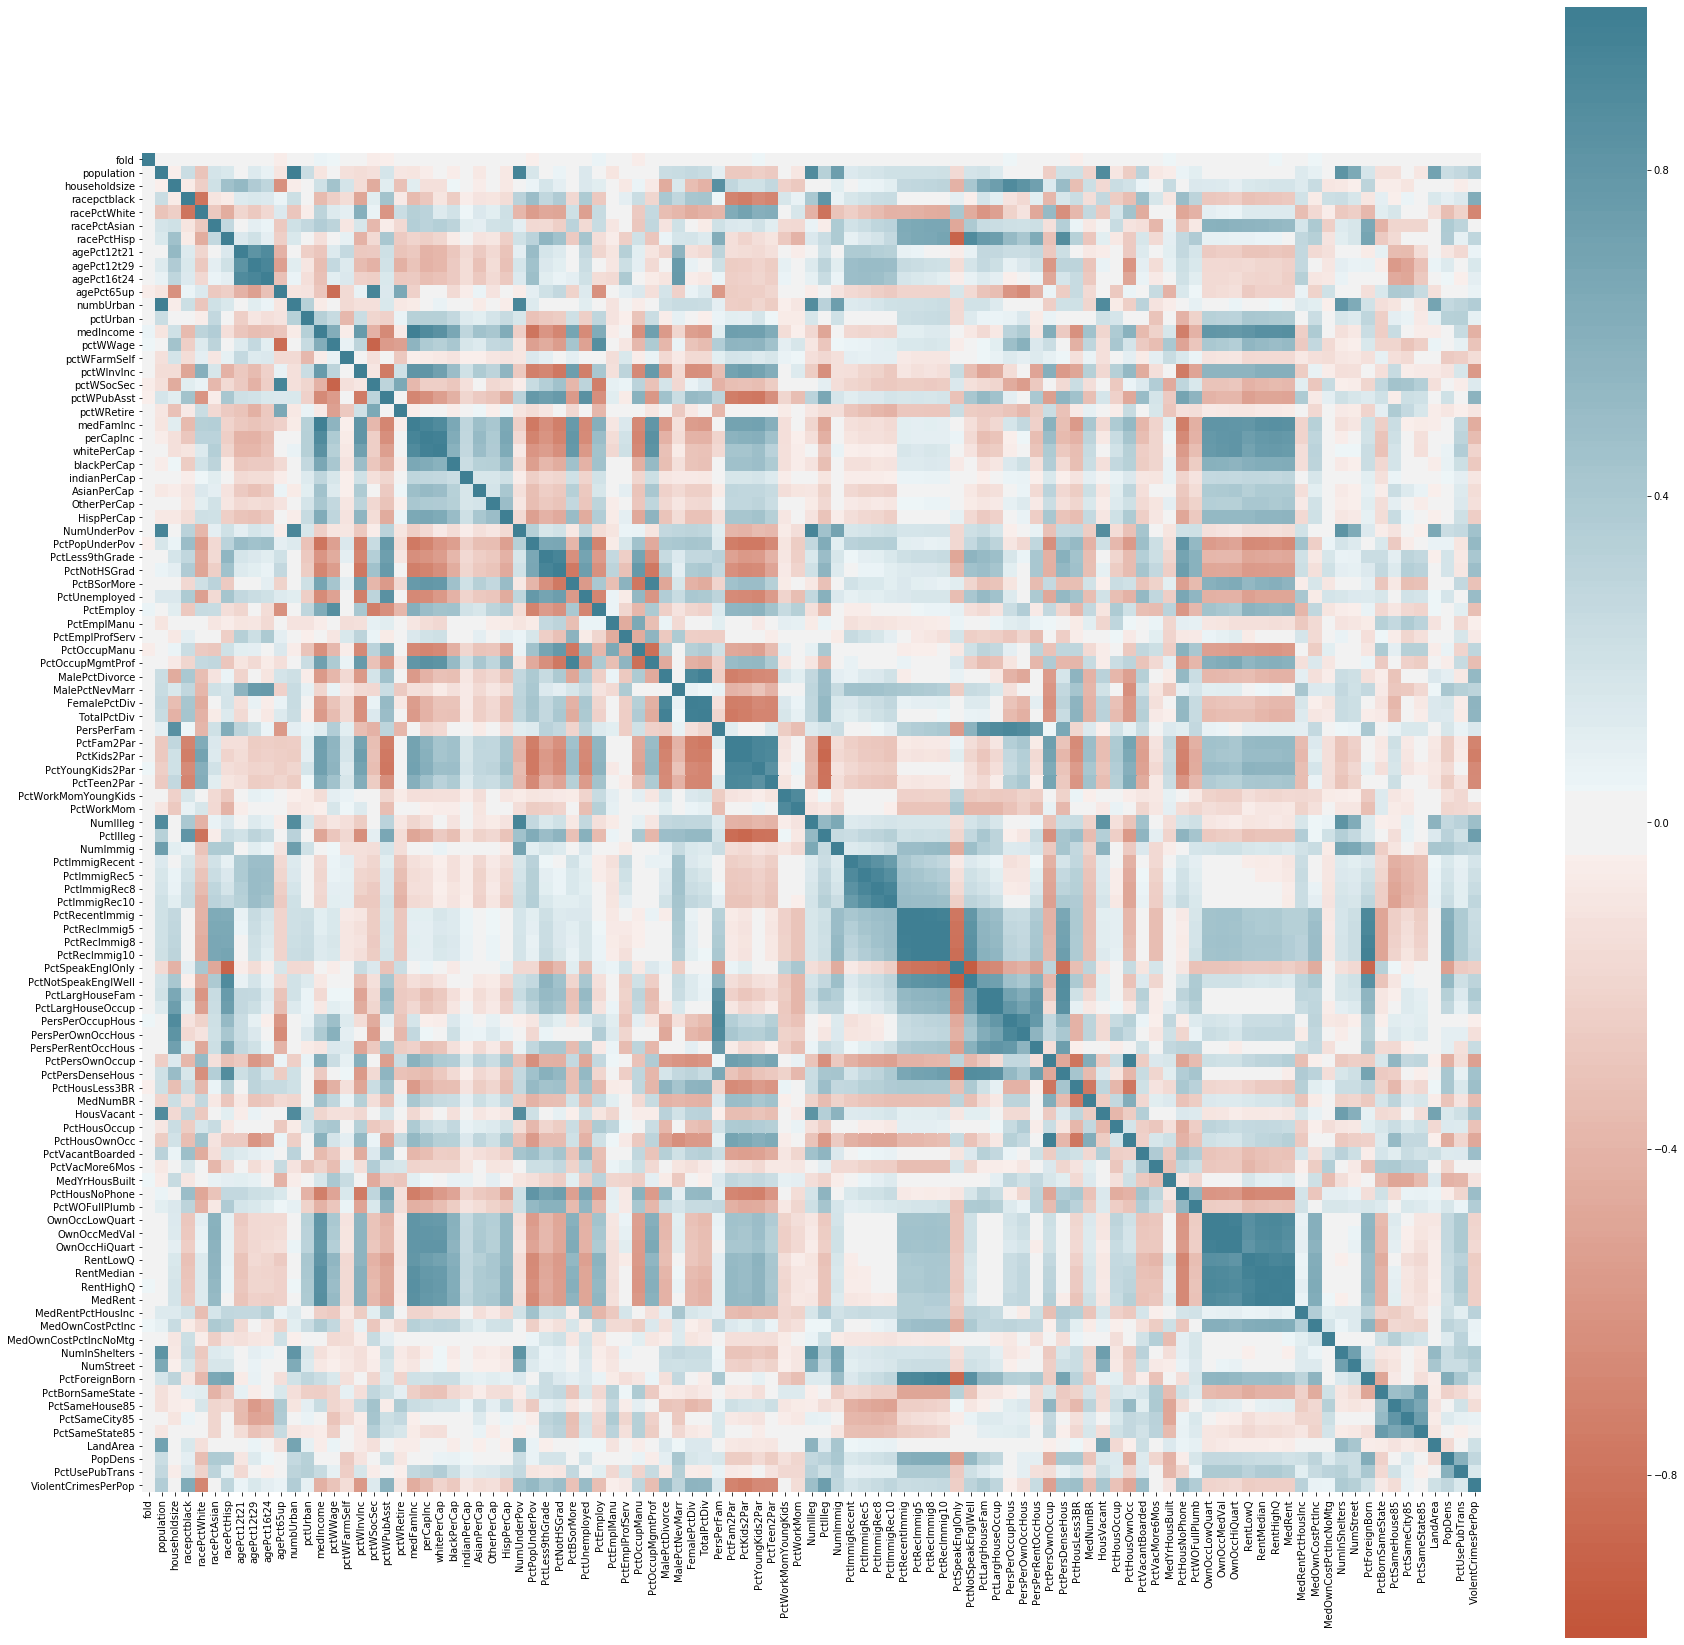

In [7]:

corr = census.corr()
#print(corr.head())

plt.figure(figsize = (30,30))
import seaborn as sns
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

Let's just restrict it to the correlations with ViolentCrimesPerPop. We can sort them.

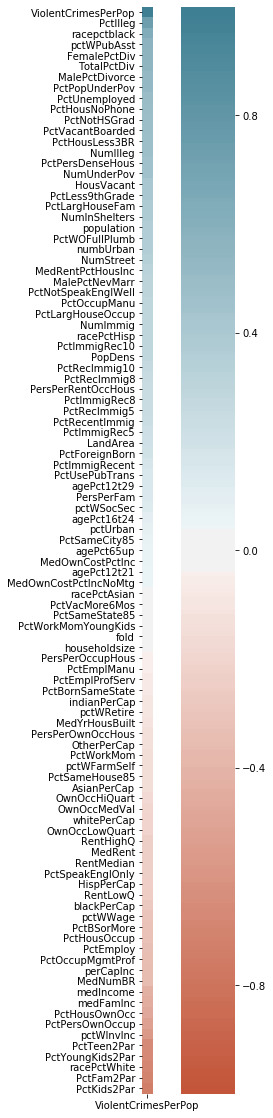

In [8]:
corr_crimes=corr[['ViolentCrimesPerPop']]

#sort by the amount of correlation
corr_crimes=corr_crimes.sort_values(by ='ViolentCrimesPerPop',ascending=False)

plt.figure(figsize = (10,20))
import seaborn as sns
ax = sns.heatmap(
    corr_crimes, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

This let's see which variables are most correlated with violent crime. This might help us choose variables to build a model by telling us (a) which variables are most likely to be good predictors and (b) which variables are likely to be simply proxies for others (so we don't include them). 

Let's go back to all the correlations (i.e. not just for correlations with violent crime). What if we wanted to automatically identify the pairs of variables with the strongest correlation? Well, of course we can do that!

Here, I'm going to restructure ("tidy") the correlation matrix, so that for each row, I have a pair of variables and their correlation. Then we can sort this by the amount of correlation.

In [9]:
# Make a copy
corr1=corr.copy()

#In the correlation matrix, each *row* has the variable name
#as the index, but we need this to be a new column
corr1.index.name = 'var1'
corr1.reset_index(inplace=True)

#Now we "melt" the table, preserving the column we've just made.
corr_pair=corr1.melt(id_vars=['var1'])
#Now we just replace the some of the column names with more sensible ones
corr_pair=corr_pair.rename(columns={'variable': 'var2','value': 'corr'})
#Now, we remove rows where var1 and var2 are the same (these are always 1)
corr_pair = corr_pair.drop(corr_pair[corr_pair['var1']==corr_pair['var2']].index)

Now we can look at the distribution of the residuals and find the top ten most positive and negative correlations. If we're still interested in those that correlate with crime, we can specify this. We might also want to sort by the absolute correlation.


Top ten most positively correlated pairs of variables
                var1            var2      corr
6019   PctRecImmig10    PctRecImmig8  0.995525
6119    PctRecImmig8   PctRecImmig10  0.995525
8261  OwnOccLowQuart    OwnOccMedVal  0.994481
8161    OwnOccMedVal  OwnOccLowQuart  0.994481
5917    PctRecImmig8    PctRecImmig5  0.993433
6017    PctRecImmig5    PctRecImmig8  0.993433
1112      population       numbUrban  0.993112
112        numbUrban      population  0.993112
8263   OwnOccHiQuart    OwnOccMedVal  0.991302
8363    OwnOccMedVal   OwnOccHiQuart  0.991302

Top ten most negatively correlated pairs of variables (in reverse order)
                     var1                 var2      corr
5196          PctKids2Par             PctIlleg -0.870198
4596             PctIlleg          PctKids2Par -0.870198
9353     PctSpeakEnglOnly       PctForeignBorn -0.877793
6253       PctForeignBorn     PctSpeakEnglOnly -0.877793
667      PctSpeakEnglOnly          racePctHisp -0.890768
6167        

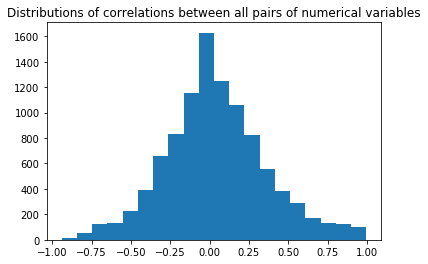

In [10]:
#We make a histogram
plt.hist(corr_pair['corr'],20)
plt.title("Distributions of correlations between all pairs of numerical variables")

#Now we sort the rows on the correlation
corr_pair=corr_pair.sort_values(by ='corr',ascending=False)

print()
print("Top ten most positively correlated pairs of variables")
print(corr_pair.head(10))

print()
print("Top ten most negatively correlated pairs of variables (in reverse order)")
print(corr_pair.tail(10))

#Add a column with the absolute correlation, so we can sort on
#amount of correlation, regardless of the sign if we want
corr_pair['abs_corr']=abs(corr_pair['corr'])
#Sort on this
corr_pair=corr_pair.sort_values(by ='abs_corr',ascending=False)

print()
print("Top ten most correlated pairs of variables with 'ViolentCrimesPerPop'")
print(corr_pair[corr_pair['var1']=='ViolentCrimesPerPop'].head(10))


These last steps are really just to illustrate the fact that Python lets us restructure our data so we can do different analyses.

Remember that all we are doing is *looking at correlations*. None of these correlations are necessary causal. Some may be. Some may just correlation with causal factors.

More about this in the Visual Analytics module.

## Part 2: Regression analysis

Now, we'll be building regression models to model the relationship between crimes and socioeconomic characteristics. 

A huge caveat when considering the regression parameters for this part is that these data are not in the original units and they are all been normalised. See the [metadata](http://www.staff.city.ac.uk/~sbbk529/Teaching/Resources/INM430/communitiesNames.txt) description. This has an impact on the way you should interpret the regression parameters. Remember that they are not in the original units!

### 1. Decide on your independent and dependent variables

In this case, we're looking to model crimes using socioeconomic data, so your *dependent variable* will be "ViolentCrimesPerPop" and your *dependent variable* will be "medIncome".

*Note* that `medIncome` may not be the best to use as it's not one of the most correlated variables (might be best to use `PctTeen2Par`). However, in analysis, we may have *other* reasons why we might want to include this. We'll include this variable later.

### 2. Build a linear regression model

The linear regression function returns 4 values, which describe our model

In [11]:
# We first use the linear regression from scipy library which
# turns 4 values. We save all the results in variables
# Notice that in addition to the slope, we also get the intercept of the line
slope, intercept, r_value, p_value, std_err = stats.linregress(column1, column2)

print ("Slope: ", slope)
print ("Intercept: ", intercept)
print ("p_value: ", p_value)
print ("std_err: ", std_err)

Slope:  -0.47208549295836494
Intercept:  0.408460041007753
p_value:  6.334424808054381e-88
std_err:  0.022578802568586777


The slope indicates that the model says that for every increase of 1 in income, the crime goes down by 0.47 of a unit (in its units - crimes per head). However, note that these are not in the original units, so you can't directly quantitatively relate to the original concepts.

### 3. Calculate regression line

You can do it directly from the slope and intercept paramters (this demonstrates how simple the idea of simple linear regression is!)

Using `np.polyval()` as suggested in the lab is unnecessary, as it's a linear equation.

Either:
1. Calculate 2 points, directly from the parameters
2. Calculate every y (dependent variable value) from every x (independent variable value, directly from the parameters
3. Use `np.polyval()`

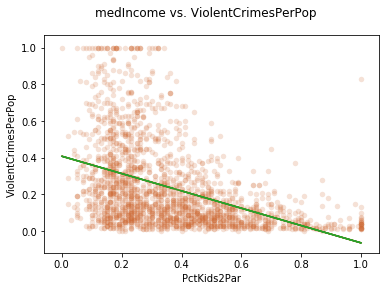

In [12]:
import numpy as np

#Method 1: Calculate 2 points directly from the parameters
x1=column1.min() #min value of the independent variable
x2=column1.max() #max value of the independent variable
y1=x1*slope + intercept #calculate the dependent variable value from x1
y2=x2*slope + intercept #calculate the dependent variable value from x2

#Method 2: Calculate every y (dependent variable value) from every x
#(independent variable value, directly from the parameters
modelledDependentMethod2  = column1*slope + intercept

#(this was the suggested method in the practical, but is unnecessary,
#because it's linear, so you only need 2 points)
modelledDependentMethod3  = np.polyval([slope, intercept], column1)

#Plot a scatterplot as before
plt.suptitle('medIncome vs. ViolentCrimesPerPop')
plt.xlabel('PctKids2Par')
plt.ylabel('ViolentCrimesPerPop')
plt.scatter(column1,column2 , c = "#D06B36", s = 30, alpha = 0.2, linewidth='0')
#overlay the modelled line (all three will be on top of each other)
#Method 1:
plt.plot([x1,x2],[y1,y2])
#Method 2:
plt.plot(column1, modelledDependentMethod2)
#Method 3:
plt.plot(column1, modelledDependentMethod3)


### 4. Comment on the model (and fit a second-order curve)

Visually, the line does not seem to fit well. This is because it's probably not a linear relationship. You can try fitting a polynomial curve. We'll try to fit a second-order curve. And here we do need to use `np.polyval()`. Most of you will have seen that the appeared to be filled in - I now realise this is because the lines joining the xs and calculated ys were not ordered, so jumping about all over the place. A solution is to sort the xs first.

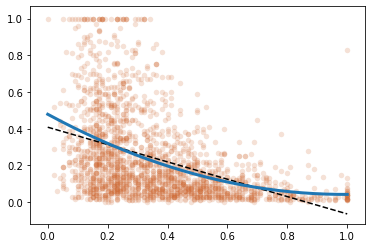

In [13]:
#Fit a second-order curve
pCoeff = np.polyfit(column1, column2, 2)
#Sort them, so the curve looks like a curve when drawn
xs = np.sort(column1)
#Calculate value for each of these using the polynomial
ys = np.polyval(pCoeff, xs)

#plot the data values
plt.scatter(column1,column2 , c = "#D06B36", s = 30, alpha = 0.2, linewidth='0')
#plot the linear "curve" - make is dashed
plt.plot([x1,x2],[y1,y2], "k--")
#plot the second order polynomal curve
plt.plot(xs, ys, linewidth = 3, fillstyle="none")

### 5. Multiple regression

We now use the `statsmodels` library to do some multiple regression.

Note that we will calculate a few of the measures manually. This is just to demonstate how this all works.

Let's add "PctTeen2Par", as the most correlated variable from the last step.

In [14]:
import statsmodels.api as sm

# our dependent variable is still "ViolentCrimesPerPop" which is still column2
dependent=column2;
# this time get two independent variables, i.e., regressors 
independents = census[["medIncome", "PctTeen2Par"]]
# We have to manually add the intercepts
independents_withconst = sm.add_constant(independents)

# we use the OLS function from statsmodels
model = sm.OLS(dependent,independents_withconst)
results = model.fit()

print (results.summary())

                             OLS Regression Results                            
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.438
Model:                             OLS   Adj. R-squared:                  0.437
Method:                  Least Squares   F-statistic:                     775.3
Date:                 Tue, 22 Oct 2019   Prob (F-statistic):          1.01e-249
Time:                         05:16:11   Log-Likelihood:                 650.16
No. Observations:                 1994   AIC:                            -1294.
Df Residuals:                     1991   BIC:                            -1278.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7065      0.013     56

/Users/sbbb717/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Have a look at [this page](http://www.datarobot.com/blog/ordinary-least-squares-in-python/) for a discussion on the values returned by the summary() function. With multiple regression, the variables interact, so we need to interpret them accordingly.

> The estimated rate of change of the conditional mean of "ViolentCrimesPerPop" (Y) with respect to "medIncome", when "PctTeen2Par" is fixed,  is between -0.163 and -0.031 units (i.e., the confidence interval). 

But remember that these don't directly relate to the original units, because the data have been normalised. However, because they are normalised, we can make direct comparisons with the coefficients. `PctTeen2Par` has a bigger effect on the model that `MedianIncome`. This is not surprising as we have already seen the `PctTeen2Par` is the most correlated.

We can calculate the crimes directly, in the same way as before. Or we can use the `predict()` method. We can get the `params` and call the `predict()` function from the model `results`.

We can't plots these as a line in 2D as before, because it's a line in 3D space. But we can calculate residuals (difference between modelled and actual crimes) and plot them as histograms.

Here, we calculate them manually using both prediction calculation methods and using `results.resid`. All three are equivalent and give the same answer.

const          0.706495
medIncome     -0.016172
PctTeen2Par   -0.793770
dtype: float64


(array([  3.,   8.,  14.,  46., 124., 273., 360., 447., 287., 135.,  94.,
         74.,  49.,  26.,  27.,  13.,   7.,   2.,   4.,   1.]),
 array([-0.53757474, -0.4675956 , -0.39761646, -0.32763732, -0.25765818,
        -0.18767904, -0.1176999 , -0.04772076,  0.02225838,  0.09223752,
         0.16221666,  0.2321958 ,  0.30217494,  0.37215408,  0.44213322,
         0.51211236,  0.5820915 ,  0.65207064,  0.72204978,  0.79202892,
         0.86200805]),
 <a list of 20 Patch objects>)

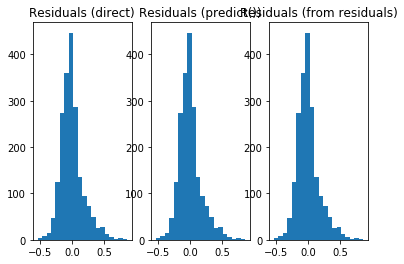

In [15]:
print(results.params)

#Calculating dependent variable values from parameters directly
modelledDependentOLSDirect  = census['medIncome']*results.params['medIncome'] + census['PctTeen2Par']*results.params['PctTeen2Par'] + results.params['const']

#Calculating dependent variable values from the predict method
modelledDependentOLSPredict  = results.predict()

#Calculate the residuals 3 ways
residualsDirect=dependent-modelledDependentOLSDirect
residualsPredict=dependent-modelledDependentOLSDirect
residualsFromLib=results.resid


#both residual distributions are the same (because both methods of
#calculating the dependent variable values are the same)
f, ax = plt.subplots(1, 3)
ax[0].set_title("Residuals (direct)")
ax[0].hist(residualsDirect,20)
ax[1].set_title("Residuals (predict())")
ax[1].hist(residualsPredict,20)
ax[2].set_title("Residuals (from residuals)")
ax[2].hist(residualsFromLib,20)

So most of the residuals are within around +/- 0.3. This means that the crimes are mostly under/over reported within around +/- 0.3. Are these residuals big (indicating a poor model) or small (indicating a good model?

Such effect sizes need to be considered within the original context of the data. However, remember that these data are not in the original units. So it might be worth considering in the context of the varition of the crime data.

0.2329849017279638


{'whiskers': [<matplotlib.lines.Line2D at 0x1a24a74a58>,
 'caps': [<matplotlib.lines.Line2D at 0x1a24a74ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a24a74630>],
 'medians': [<matplotlib.lines.Line2D at 0x1a24a7e828>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a24a7eb70>],
 'means': []}

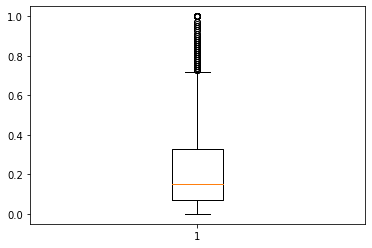

In [16]:
print(dependent.std())
plt.boxplot(dependent)

As discussed, these data are not in the original meaningful units - they are range-normalised to between 0-1, and has a standard deviation of 0.23. This gives you the text with which to consider your answer. These residuals are quite large, but not really large, indicating that it describes at least some of the variation in the data.

This is confirmed with more standard measures that you can extract from `results`.

In [17]:
print("R-squared:",results.rsquared)
print("MSE model:",results.mse_model)
print("MSE residuals:",results.mse_resid)
print("MSE total:",results.mse_total)

R-squared: 0.43781818848568765
MSE model: 23.68245162590887
MSE residuals: 0.03054698737495143
MSE total: 0.05428196443318918


The r-squared is quite high indicating a reasonable model. Again, see [this page](http://www.datarobot.com/blog/ordinary-least-squares-in-python/) for how to interpret these things.


### 6. R-style functions

This is just an alternative way of specifying a model.

In [210]:
# This method uses R style patsy formulas to indicate the relations
# Have a look at the patsy documentation if you like to read more.
# But within the scope of this course we will not go into its details
model2 = sm.formula.ols(formula='ViolentCrimesPerPop ~ medIncome + PctTeen2Par', data=census, hasconst = False)
results2 = model2.fit()

print ("Params 2: ", results2.summary())
print ("---------------------------------------------")

Params 2:                                   OLS Regression Results                                 
Dep. Variable:     ViolentCrimesPerPop   R-squared (uncentered):                   0.725
Model:                             OLS   Adj. R-squared (uncentered):              0.725
Method:                  Least Squares   F-statistic:                              1749.
Date:                 Mon, 21 Oct 2019   Prob (F-statistic):                        0.00
Time:                         22:20:13   Log-Likelihood:                          650.16
No. Observations:                 1994   AIC:                                     -1294.
Df Residuals:                     1991   BIC:                                     -1278.
Df Model:                            3                                                  
Covariance Type:             nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------